In [1]:
#Standard libraries
import os
import datetime as dt

# 3rd party libraries
import pandas as pd
import numpy as np
import scipy.signal as ss
import statsmodels.api as smf
from patsy import dmatrix, dmatrices

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

D:\ProgramFiles\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
SCRIPT_DIR = os.getcwd()
PAR_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
DATA_DIR = os.path.join(PAR_DIR, 'Data')
OUTPUT_DIR = os.path.join(PAR_DIR, 'Output')

In [3]:
dengai_train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'))
dengai_train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'))
dengai_test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'))

In [49]:
formula1 = """
            total_cases ~ C(city) + year_o + week_start_date_o + 
            ndvi_ne + ndvi_nw + ndvi_se + ndvi_sw +
            precipitation_amt_mm + reanalysis_air_temp_k + reanalysis_avg_temp_k + 
            reanalysis_dew_point_temp_k + reanalysis_max_air_temp_k + 
            reanalysis_min_air_temp_k + reanalysis_precip_amt_kg_per_m2 + 
            reanalysis_relative_humidity_percent + reanalysis_sat_precip_amt_mm + 
            reanalysis_specific_humidity_g_per_kg + reanalysis_tdtr_k +
            station_avg_temp_c + station_diur_temp_rng_c + station_max_temp_c + 
            station_min_temp_c + station_precip_mm
            """
formula2 = """
            total_cases ~ C(city) + week_start_date_o + ndvi_ne + ndvi_nw + ndvi_se + ndvi_sw
            """
formula3 = """
            total_cases ~ C(city) + year_o + week_start_date_o + 
            week_start_date + ndvi_ne + ndvi_nw + ndvi_se + ndvi_sw +
            precipitation_amt_mm + reanalysis_air_temp_k + reanalysis_avg_temp_k 
            """

In [50]:
# Concatenate training data labels with the features
full_data = pd.concat((dengai_train_labels['total_cases'], dengai_train_features), axis=1)
full_data['week_start_date_o'] = pd.to_datetime(full_data['week_start_date']).map(dt.datetime.toordinal)
full_data['year_o'] = pd.to_datetime(full_data['year']).map(dt.datetime.toordinal)
full_data = full_data.fillna(full_data.mean())
outcome, predictors = dmatrices(formula1, full_data, return_type='dataframe')


In [51]:
train_cutoff = int(np.ceil(0.65 * predictors.shape[0]))
dev_cutoff = int(np.ceil(0.90 * predictors.shape[0]))

outcome_train, predictors_train = outcome[:train_cutoff], predictors[:train_cutoff]
outcome_dev, predictors_dev = outcome[train_cutoff:dev_cutoff], predictors[train_cutoff:dev_cutoff]
outcome_test, predictors_test = outcome[dev_cutoff:], predictors[dev_cutoff:]

print(predictors_train.shape, predictors_dev.shape, predictors_test.shape)

(947, 24) (364, 24) (145, 24)


In [58]:
poisson_model = smf.GLM(outcome_train, predictors_train, family=smf.families.Poisson())
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  947
Model:                            GLM   Df Residuals:                      925
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -17264.
Date:                Thu, 14 Dec 2017   Deviance:                       30070.
Time:                        22:22:08   Pearson chi2:                 4.61e+04
No. Iterations:                    10                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              5.511e-10   4.86e-11     11.347      0

(array([ 310.,   36.,   13.,    3.,    0.,    0.,    0.,    1.,    0.,    1.]),
 array([   0. ,   11.6,   23.2,   34.8,   46.4,   58. ,   69.6,   81.2,
          92.8,  104.4,  116. ]),
 <a list of 10 Patch objects>)

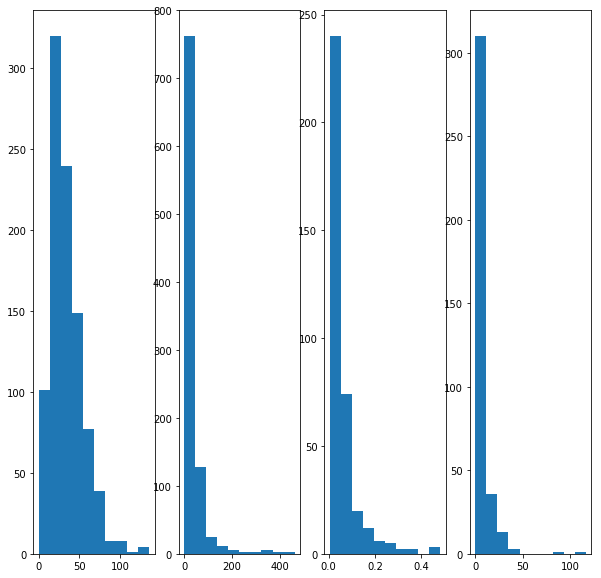

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].hist(poisson_results.fittedvalues)
ax[1].hist(outcome_train.values)
ax[2].hist(predictions.values)
ax[3].hist(outcome_dev.values)
